In [1]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup

### I am going to scrape three years (2017,2018,2019) of NFL draft data from https://www.pro-football-reference.com. The format for each draft year's url is "https://www.pro-football-reference.com/years/{year}/draft.htm" where {year} is substituted for the desired year of the draft. To scrape the three years, we create a list of the draft years and run a for loop to create a url for each year. Then we create a response object using a get request for each url and then pass that response to BeautifulSoup to create a bs4 object. After inspecting the webpage we find that the table we want is id="drafts". We create a table from this data by searching for 'table', {'id': 'drafts'} in the soup object (see snapshot below).

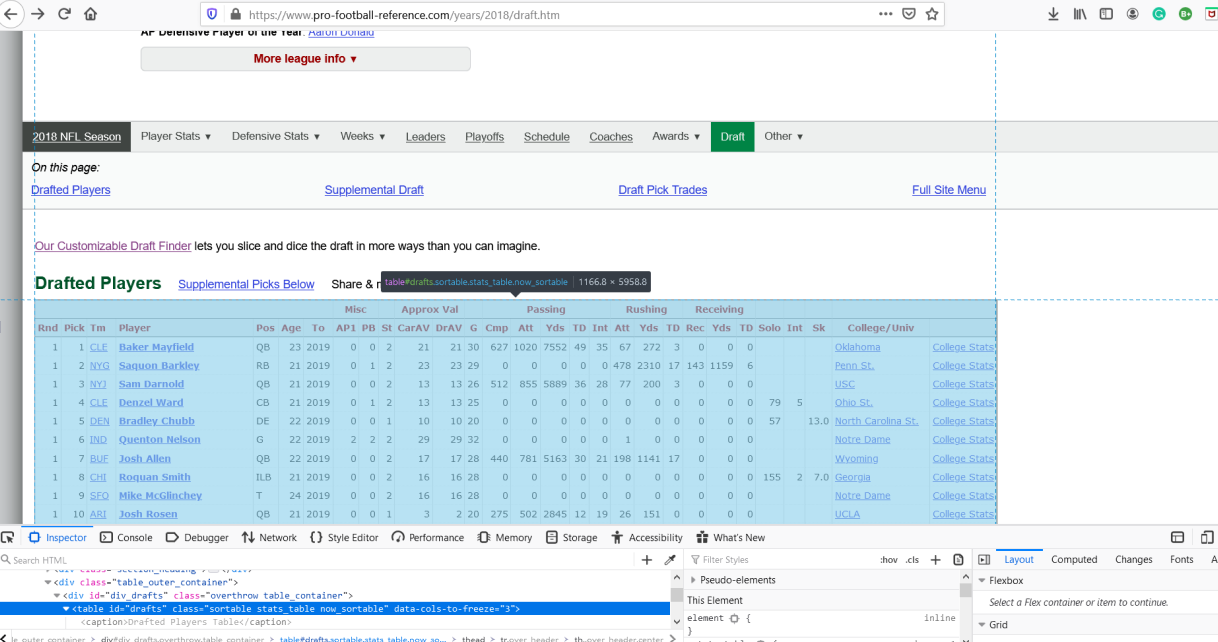

In [2]:
# Create an empty list to store each df
list_of_df = []
for year in [2017,2018,2019]:
    url = "https://www.pro-football-reference.com/years/{year}/draft.htm".format(year=year)
    response = get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'id': 'drafts'})
    df = pd.read_html(str(table))[0]
    
    # Data cleansing step 1 - drop the first level of the headers
    df.columns = df.columns.droplevel(level = 0)
    # Data cleansing step 2 - get rid of duplicate rows
    # There are multiple rows of the column names for readability but they must be removed.
    df = df[df['Pos'] != 'Pos']
    # Data cleansing step 3 - We want to store the year each player was drafted into that draft year's df.
    # The current table stores the most recently played season. To update this with the correct value,
    # we set the 'To' column = year, which is the draft year the player was taken.
    df['To'] = year
    list_of_df.append(df)

In [3]:
# We concatenate the three dataframes together
concat_df = pd.concat(list_of_df, sort=False)

In [4]:
# Inspect the columns of the df
concat_df.columns

Index(['Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1', 'PB', 'St',
       'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att', 'Yds',
       'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk', 'College/Univ',
       'Unnamed: 28_level_1'],
      dtype='object')

### The headers were imported automatically with the df import. If we wanted to extract them from the webpage, we would use the following code.

In [5]:
table2 = soup.find('thead')
match = table2.find_all('th')
headers = [match[i].get_text().strip() for i in range(12,41)]
headers

['Rnd',
 'Pick',
 'Tm',
 'Player',
 'Pos',
 'Age',
 'To',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Cmp',
 'Att',
 'Yds',
 'TD',
 'Int',
 'Att',
 'Yds',
 'TD',
 'Rec',
 'Yds',
 'TD',
 'Solo',
 'Int',
 'Sk',
 'College/Univ',
 '']

### We want to update the headers, since some are ambiguous and some are repeated due to the multiple level table header. Looking at the webpage, the first set of 'Att', 'Yds', and 'TD' should be passing statistics. The second set of 'Att', 'Yds', and 'TD' should be rushing statistics. The third set of 'Yds' and 'TD' should be receiving statistics. We will also change headers to have more meaningful names.


In [6]:
# Data Cleaning step # 4 - renaming headers. We will save the headers as our column names when we are finished.
headers[2] = 'Team'
headers[6] = 'Draft_year'
headers[13] = 'Pass_comp'
headers[14] = 'Pass_att'
headers[15] = 'Pass_yds'
headers[16] = 'Pass_TD'
headers[17] = 'Pass_INT'
headers[18] = 'Rush_att'
headers[19] = 'Rush_yds'
headers[20] = 'Rush_TD'
headers[21] = 'Receptions'
headers[22] = 'Rec_yds'
headers[23] = 'Rec_TD'
headers[24] = 'Tackles'
headers[26] = 'Sacks'

In [7]:
headers

['Rnd',
 'Pick',
 'Team',
 'Player',
 'Pos',
 'Age',
 'Draft_year',
 'AP1',
 'PB',
 'St',
 'CarAV',
 'DrAV',
 'G',
 'Pass_comp',
 'Pass_att',
 'Pass_yds',
 'Pass_TD',
 'Pass_INT',
 'Rush_att',
 'Rush_yds',
 'Rush_TD',
 'Receptions',
 'Rec_yds',
 'Rec_TD',
 'Tackles',
 'Int',
 'Sacks',
 'College/Univ',
 '']

In [8]:
# Set the column names = headers
concat_df.columns = headers

In [9]:
# Drop the blank header
concat_df.drop([''], axis=1, inplace=True)

In [10]:
# Check the data types 
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 259
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rnd           763 non-null    object
 1   Pick          763 non-null    object
 2   Team          763 non-null    object
 3   Player        763 non-null    object
 4   Pos           763 non-null    object
 5   Age           763 non-null    object
 6   Draft_year    763 non-null    int64 
 7   AP1           763 non-null    object
 8   PB            763 non-null    object
 9   St            763 non-null    object
 10  CarAV         675 non-null    object
 11  DrAV          646 non-null    object
 12  G             675 non-null    object
 13  Pass_comp     675 non-null    object
 14  Pass_att      675 non-null    object
 15  Pass_yds      675 non-null    object
 16  Pass_TD       675 non-null    object
 17  Pass_INT      675 non-null    object
 18  Rush_att      675 non-null    object
 19  Rush_yds

### We want all but 4 of our columns data types to be numeric. In order to do that we make a list of the columns to exclude from conversion and then subtract those from columns list. Then we will apply pd.to_numeric to change the desired columns' data types to numeric.

In [11]:
cols_to_exclude = ['Team','Player','Pos','College/Univ']
final_list= list(set(concat_df.columns).difference(set(cols_to_exclude)))
final_list

['Draft_year',
 'Rec_TD',
 'Pick',
 'PB',
 'Pass_INT',
 'CarAV',
 'Pass_TD',
 'Age',
 'Rush_yds',
 'Rec_yds',
 'Int',
 'Rnd',
 'Rush_TD',
 'G',
 'Pass_yds',
 'Pass_att',
 'Tackles',
 'Receptions',
 'St',
 'DrAV',
 'Pass_comp',
 'AP1',
 'Rush_att',
 'Sacks']

In [12]:
# Data Cleaning step #5 - changing multiple column data types to numeric using apply.
concat_df[final_list] = concat_df[final_list].apply(pd.to_numeric)

In [13]:
# Data Cleaning step #6 - create a pass completion % column by dividing 'Pass_comp' by 'Pass_att' and multiplying by 100.
Pass_comp_pcnt = round((concat_df['Pass_comp']/concat_df['Pass_att']),3)*100

In [14]:
# Insert the column into the appropriate part of the dataframe
concat_df.insert(13, 'Pass_comp%', Pass_comp_pcnt)

In [15]:
concat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 763 entries, 0 to 259
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Rnd           763 non-null    int64  
 1   Pick          763 non-null    int64  
 2   Team          763 non-null    object 
 3   Player        763 non-null    object 
 4   Pos           763 non-null    object 
 5   Age           763 non-null    int64  
 6   Draft_year    763 non-null    int64  
 7   AP1           763 non-null    int64  
 8   PB            763 non-null    int64  
 9   St            763 non-null    int64  
 10  CarAV         675 non-null    float64
 11  DrAV          646 non-null    float64
 12  G             675 non-null    float64
 13  Pass_comp%    37 non-null     float64
 14  Pass_comp     675 non-null    float64
 15  Pass_att      675 non-null    float64
 16  Pass_yds      675 non-null    float64
 17  Pass_TD       675 non-null    float64
 18  Pass_INT      675 non-null    

In [16]:
concat_df.head()

,Rnd,Pick,Team,Player,Pos,Age,Draft_year,AP1,PB,St,...,Rush_att,Rush_yds,Rush_TD,Receptions,Rec_yds,Rec_TD,Tackles,Int,Sacks,College/Univ
0,1,1,CLE,Myles Garrett,DE,21,2017,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,74.0,NaN,30.5,Texas A&M
1,1,2,CHI,Mitchell Trubisky,QB,23,2017,0,1,3,...,157.0,862.0,7.0,0.0,0.0,0.0,NaN,NaN,NaN,North Carolina
2,1,3,SFO,Solomon Thomas,DE,22,2017,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,73.0,NaN,6.0,Stanford
3,1,4,JAX,Leonard Fournette,RB,22,2017,0,0,3,...,666.0,2631.0,17.0,134.0,1009.0,2.0,NaN,NaN,NaN,LSU
4,1,5,TEN,Corey Davis,WR,22,2017,0,0,3,...,6.0,55.0,0.0,142.0,1867.0,6.0,NaN,NaN,NaN,West. Michigan
